# Approach

The primary objective of this project is to analyze textual feedback and classify both the sentiment and the topic of each comment. By doing this, we aim to derive sentiment distribution per topic, providing insights into how different topics affect the overall sentiment of the feedback.

# Imports

In [24]:
# Standard libraries
import os
import re

# Third-party libraries
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from openai import OpenAI

# Data visualization
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Natural Language Processing (NLP)
from transformers import pipeline

# Data

In [2]:
df = pd.read_csv("data/amazon_reviews.csv")
df.shape

(4915, 12)

In [3]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


# Preprocess

Since we are using a Large Language Model (LLM), extensive text preprocessing is not required. We only need to perform basic preprocessing to ensure the input consists of valid strings and clean text, ready for analysis.

In [4]:
def preprocess(text):
    """
    Preprocesses the given text by removing duplicate symbols and extra whitespaces.
    
    Args:
        text (str): The input text to be preprocessed.
    
    Returns:
        str: The preprocessed text.
    """
    # Remove duplicate symbols.
    text = re.sub(r'([^\w\s])\1+', r'\1', text)
    
    # Remove extra whitespaces.
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Check if the string length is 1, if so, return an empty string.
    if len(text) == 1:
        return ""
    return text

We need to ensure that the `reviewText` column does not contain any null values, as we are only interested in text data in string format.

In [5]:
if df['reviewText'].isnull().any():
    print(f"There are {df['reviewText'].isnull().sum()} null values in the column '{'reviewText'}'.")
else:
    print("No null values found.")

Attention: There are 1 null values in the column 'reviewText'.


In [6]:
df.dropna(subset=['reviewText'], inplace=True)
df.shape

(4914, 12)

In [7]:
non_string_values = df[~df['reviewText'].apply(lambda x: isinstance(x, str))]

if not non_string_values.empty:
    print(f"Attention: There are {len(non_string_values)} values that are not strings in the column '{'reviewText'}'.")
    print("Examples of non-string values:")
    print(non_string_values['reviewText'].head())  
else:
    print("All values in the column are strings.")

All values in the column are strings.


In [8]:
df['processed_comment'] = df['reviewText'].apply(preprocess) # Applying the preprocess function to each comment

# EDA

## Rating 

The first step is to examine whether there is any bias in the ratings. This is crucial for sentiment analysis, as we can anticipate a correlation between the sentiment expressed in the text and the associated ratings.

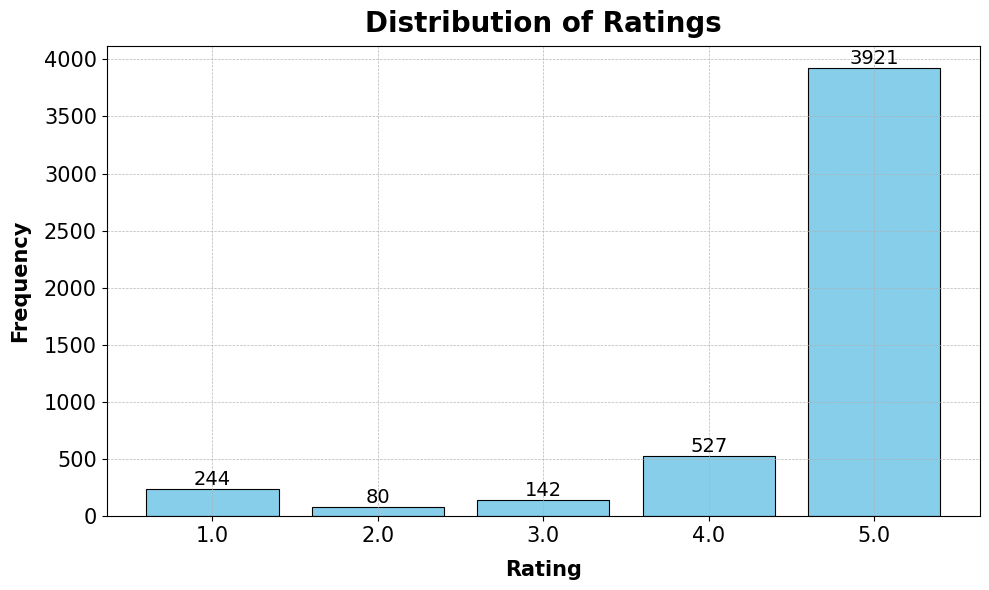

In [9]:
#First plot is to see if our dataset have a bias for a rate (overall)

rating_counts = df['overall'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
bars = plt.bar(rating_counts.index, rating_counts, color='skyblue', edgecolor='black', linewidth=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, int(yval), ha='center', va='bottom', fontsize=14)

plt.xlabel('Rating', fontsize=15, labelpad=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=15, labelpad=10, fontweight='bold')
plt.title('Distribution of Ratings', fontsize=20, pad=10, fontweight='bold')
plt.xticks(ticks=rating_counts.index, labels=rating_counts.index, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.9)
plt.tight_layout()
plt.show()

As observed, the dataset is predominantly positive, so we can expect the sentiment analysis to yield more positive feedback as a result.

## Trend

An important trend to consider is that users who provide lower ratings are more likely to leave comments, and these comments tend to be longer. This presents a valuable opportunity to investigate the content of negative feedback, as it may highlight critical issues affecting the performance of our application. Understanding these comments could help address underlying problems and improve user satisfaction.

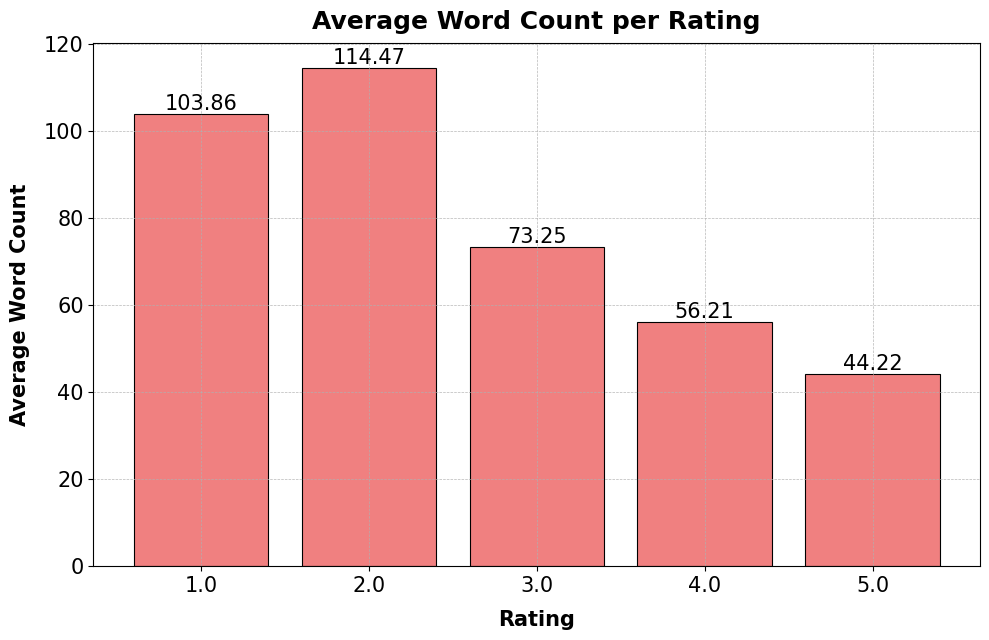

In [10]:
# Using split to calculate the number of words in each comment
df['Word Count'] = df['reviewText'].apply(lambda x: len(x.split()))

# Calculating the average word count per rating
average_word_count = df.groupby('overall')['Word Count'].mean()
average_word_count_df = average_word_count.reset_index()

# Plot to visualize the average word count per rating
plt.figure(figsize=(10, 6.5))
bars = plt.bar(average_word_count.index, average_word_count, color='lightcoral', edgecolor='black', linewidth=0.8)

# Adding text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=15)

plt.xlabel('Rating', fontsize=15, labelpad=10, fontweight='bold')
plt.ylabel('Average Word Count', fontsize=15, labelpad=10, fontweight='bold')
plt.title('Average Word Count per Rating', fontsize=18, pad=10, fontweight='bold')
plt.xticks(ticks=average_word_count.index, labels=average_word_count_df['overall'], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.9)
plt.tight_layout()
plt.show()

This confirms our expectation: 
- lower ratings (1 and 2) tend to have a higher average word count, 
- higher ratings have fewer words on average. 

This suggests that more satisfied customers are less likely to leave lengthy comments.

# Sentiment Analysis

For this task, we will utilize the OpenAI API, specifically the GPT-4o model. A straightforward prompt will be used to classify the sentiment into one of three categories: negative, neutral, or positive.

In [11]:
tqdm.pandas(desc="Processing sentiments") # Adds a progress bar when applying the lambda function

In [12]:
client = OpenAI(
    api_key=os.getenv('API_KEY'),
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o",
)

In [13]:
def get_sentiment(text):
    try:
        completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a sentiment analysis assistant. Your task is to classify the sentiment of a given text as 'positive', 'negative', or 'neutral' based on its content."},
            {
                "role": "user",
                "content": f"The following text is feedback from a user answering the question: 'Do you have any feedback or suggestions?'. Please classify its sentiment as 'positive', 'negative', or 'neutral': '{text}'."
            }
        ]
    )
        match = re.search(r"negative|neutral|positive", completion.choices[0].message.content.strip(), re.IGNORECASE)
        if match:
            return match.group(0).lower()
        else:
            print(f"No valid sentiment found in response: {completion.choices[0].message.content.strip()}")
            return "undefined"
        
    except Exception as e:
        print(f"Error processing text: '{text}' | Exception: {e}")
        return "Error"

In [14]:
df['sentiment'] = df['processed_comment'].progress_apply(get_sentiment)

Processing sentiments:   0%|          | 0/4914 [00:00<?, ?it/s]

In [15]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_labels = sentiment_counts.index.tolist()
sentiment_values = sentiment_counts.values.tolist()

In [16]:
sentiment_labels = ['positive', 'neutral', 'negative']

## Overall Sentiment

In [23]:
# This script visualizes sentiment analysis results using two types of charts: a bar chart and a pie chart.
# The first chart is a grouped bar chart that displays sentiment counts for each category (positive, neutral, negative).
# The second chart is a pie chart showing the proportion of each sentiment category.
# Both charts use custom colors for consistency across visualizations.

colors = {'positive': '#6BCD53', 'neutral': 'orange', 'negative': '#FF6347'}

# Sorting the colors according to the sentiment labels for consistent application in both charts.
sorted_colors = [colors[label] for label in sentiment_labels]

# Creating a layout with two subplots: one for the bar chart and one for the pie chart.
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'bar'}, {'type':'domain'}]])

# The bars are colored according to the sentiment, and the text is positioned for clear visibility.
fig.add_trace(
    go.Bar(
        x=sentiment_labels, 
        y=sentiment_values, 
        marker_color=sorted_colors, 
        text=sentiment_values, 
        textposition='inside', 
        showlegend=False,
        hoverinfo='y',
        textfont=dict(size=18)
    ),
    row=1, col=1
)

# Adding a pie chart to the second subplot, representing the sentiment distribution as percentages.
fig.add_trace(
    go.Pie(
        labels=sentiment_labels, 
        values=sentiment_values, 
        hole=.4, 
        marker=dict(colors=sorted_colors), 
        hoverinfo='label+percent',
        textfont=dict(size=18)
    ),
    row=1, col=2
)

fig.update_layout(
    title_text='Sentiment Distributions',
    title_x=0.5,  
    title_font=dict(size=24),  
    annotations=[
        dict(text='Sentiment Count', x=0.11, y=1.1, xref='paper', yref='paper', showarrow=False, font=dict(size=20)),
        dict(text='Sentiment Percentage', x=0.92, y=1.1, xref='paper', yref='paper', showarrow=False, font=dict(size=20))
    ],
    width=1000, 
    height=500   
)

fig.show()


This was expected, since we saw that the higher values of Ratings are in rating 4 to 5, this means, very good rates.

But to confirme more clearly about that, we now go see a plot with the correlation between the rating and the sentiment.

## Correlation between sentiment and rating

In [119]:
# Step 1: Aggregate the data by 'Rating' and 'Sentiment' category
sentiment_by_rating = df.groupby(['overall', 'sentiment']).size().unstack(fill_value=0)

# Step 2: Extract the 'overall' rating categories and the 'sentiment' labels
categories = sentiment_by_rating.index
labels = sentiment_by_rating.columns

# Step 3: Convert the DataFrame's sentiment counts into a list of numpy arrays
data = [sentiment_by_rating[label].values for label in labels]

# Step 4: Define the width of each bar in the bar chart
bar_width = 0.25  # This controls the thickness of each bar in the grouped bar chart.

# Step 5: Calculate the x-axis positions for each group of bars
# 'r1' is the starting position for the first group of bars (negative sentiment).
# 'r2' is the starting position for the second group of bars (neutral sentiment), shifted by the bar width.
# 'r3' is for the third group (positive sentiment), also shifted accordingly.
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Step 6: Initialize the Plotly figure for the grouped bar chart
fig = go.Figure()

# Step 7: Add the first set of bars representing 'Negative' sentiment
fig.add_trace(go.Bar(
    x=r1,  
    y=data[0],  
    name='Negative', 
    marker_color='#FF6347', 
    width=bar_width,  
    text=data[0],  
    textposition='outside',  
    textfont=dict(size=18) 
))

# Step 8: Add the second set of bars for 'Neutral' sentiment
fig.add_trace(go.Bar(
    x=r2,  
    y=data[1], 
    name='Neutral',  
    marker_color='orange',  
    width=bar_width, 
    text=data[1],  
    textposition='outside',  
    textfont=dict(size=18)  
))

# Step 9: Add the third set of bars for 'Positive' sentiment
fig.add_trace(go.Bar(
    x=r3,  
    y=data[2],  
    name='Positive',  
    marker_color='#6BCD53',  
    width=bar_width, 
    text=data[2],  
    textposition='outside',  
    textfont=dict(size=18) 
))

fig.update_layout(
    title='Sentiment Distribution by Rating',  
    xaxis=dict(
        title='Rating',  
        title_font={"size": 20}, 
        tickmode='array',  
        tickvals=[r + bar_width for r in range(len(r1))],  
        ticktext=[str(rating) for rating in categories], 
        tickfont={"size": 20},  
        range=[-0.2, len(categories) - 0.98 + bar_width * 3]  
    ),
    yaxis=dict(
        title='Count', 
        title_font={"size": 20},  
        tickfont={"size": 20}  
    ),
    barmode='group',  
    margin=dict(l=40, r=40, t=40, b=40),  
    legend_title="",  
    legend_title_font={"size": 20},  
    legend=dict(
        font=dict(size=20)  
    ),
    width=1200,  
    height=700  
)

fig.show()


As observed, there is a strong concentration of positive sentiments in the 5-star ratings, with a clear decline as the ratings decrease. 

This trend indicates that the sentiment classification aligns well with the expected pattern, suggesting the model is correctly associating higher ratings with more positive feedback and lower ratings with more negative sentiments. This consistency reinforces the accuracy of the sentiment analysis in capturing the relationship between customer satisfaction and rating.

## Sentiment Overtime

Analyzing sentiment over time offers a valuable overview of what is happening with our application, providing critical insights. This can help identify correlations, such as the impact of a new release, product feature, or update on user feedback.

Additionally, the contrast between negative and positive sentiments is clearly visible, highlighting areas that require deeper investigation to understand potential issues or successes.

In [141]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%Y-%m-%d')

# Group by month (from 'reviewTime') and sentiment, and count the occurrences
df_grouped_by_month = df.groupby([df['reviewTime'].dt.to_period('M'), 'sentiment']).size().unstack(fill_value=0)

print(df_grouped_by_month.head())

sentiment   negative  neutral  positive
reviewTime                             
2012-01            0        1        10
2012-02            2        1        14
2012-03            0        1         6
2012-04            2        4         5
2012-05            3        2        12


In [142]:
# This code generates a time-series plot showing the normalized proportions of sentiments (positive, neutral, negative) over time.

df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%Y-%m-%d')
df_grouped = df.groupby([df['reviewTime'].dt.to_period('M'), 'sentiment']).size().unstack(fill_value=0)
df_grouped.index = df_grouped.index.to_timestamp()

daily_totals = df_grouped.sum(axis=1)
normalized_sentiments = df_grouped.divide(daily_totals, axis=0)

fig_time_series = go.Figure()
colors = {'positive': '#6BCD53', 'neutral': 'orange', 'negative': '#FF6347'}

for sentiment, color in colors.items():
    if sentiment in normalized_sentiments:
        fig_time_series.add_trace(go.Scatter(
            x=normalized_sentiments.index,
            y=normalized_sentiments[sentiment],
            mode='lines',
            name=sentiment,
            line=dict(color=color, width=2)
        ))

fig_time_series.update_layout(
    width=1000,
    height=400,
    title={
        'text': 'Normalized Sentiment Analysis Over Time',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Arial, sans-serif",
            size=24,
            color="black"
        ),
    },
    xaxis_title='Date',
    yaxis_title='Proportion',
    xaxis=dict(
        title_font=dict(size=18, color='black'),
        tickfont=dict(size=16, color='black'),
        tickcolor='black'
    ),
    yaxis=dict(
        title_font=dict(size=18, color='black'),
        tickfont=dict(size=16, color='black'),
        tickcolor='black'
    ),
    legend_title='Sentiment',
    legend=dict(
        title_font=dict(size=14, color='black'),
        font=dict(size=12, color='black')
    ),
    template='plotly_white',
    plot_bgcolor='rgba(255, 255, 255, 1)',
    paper_bgcolor='rgba(255, 255, 255, 1)'
)

fig_time_series.show()


# Topic Classification

For the topic classification, I will use a different Large Language Model (LLM) instead of OpenAI's models. The goal is to explore an alternative approach and demonstrate the use of another LLM.

The chosen model is DeBERTa Large, fine-tuned for Zero-Shot classification.

You can find the documentation here: [DeBERTa-v3-large-zeroshot-v2.0.](https://huggingface.co/MoritzLaurer/deberta-v3-large-zeroshot-v2.0)

## Approach

1. To enable Zero-Shot topic classification, I predefined general topics commonly found in feedback on platforms like Amazon. These include:
    - Price
    - Quality
    - Product functionality 
    - Compatibility with devices (e.g., SD cards, phones, and cameras)
    - Delivery Service

2. There are multiple ways to provide context to the model. I chose to offer a context that includes a brief summary of what each topic represents. This context will be referred to as feature descriptions.

In [17]:
features_description = {
    "Price": "Evaluation of the product's cost, whether it's considered affordable, expensive, or offers good value for the price paid compared to similar products.",

    "Quality": "Assessment of the product's durability, materials used, reliability, and overall build quality, including whether it meets customer expectations for longevity and performance.",

    "Product functionality": "How effectively the product fulfills its intended purpose, including performance, ease of use, and whether it works as described or expected by the customer.",

    "Compatibility with devices": "Whether the product functions well with other devices, such as SD cards, phones, or cameras, and how seamlessly it integrates or adapts to different systems.",

    "Delivery Service": "Customer experience regarding shipping speed, packaging quality, condition of the product upon arrival, and how reliable the delivery process was overall."
}

In [18]:
deberta_classifier = pipeline("zero-shot-classification",
                      model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0",
                      batch_size=2)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [19]:
def get_topics(text, input_features):
    """
    Classifies the provided text into topics or keywords based on the type of `input_features` (list or dict).

    Args:
        text (str): The text to be classified.
        classifier (callable): The classification model to be used.
        input_features (list or dict): A list of topics or a dictionary of categories with keywords.

    Returns:
        dict: A dictionary with topics or categories as keys and their respective confidences as values, summing up to 1 (100%).

        Example: {'usability': 0.8, 'performance': 0.1, 'quality': 0.05, 'error handling': 0.03, 'personal data': 0.02}
    """
   
    #TOPICS DESCRIPTIONS
    if isinstance(input_features, dict):
        # Create a reverse mapping from descriptions to category names
        description_to_category = {description: category for category, description in input_features.items()}
        descriptions = list(input_features.values())

        # Classify using the descriptions
        result = deberta_classifier(text, descriptions, multi_label=False)
        sorted_descriptions = sorted(zip(result['labels'], result['scores']), key=lambda x: x[1], reverse=True)

        # Map sorted descriptions back to categories and record scores
        category_scores = {}
        for description, score in sorted_descriptions:
            category = description_to_category[description]
            if category not in category_scores or score > category_scores[category]:
                category_scores[category] = score

            top_topic, top_score = max(category_scores.items(), key=lambda item: item[1])
  
        return top_topic
        
      
    
    else:
        raise ValueError("input_features must be either a list of topics or a dictionary of categories with descriptions.")

In [20]:
tqdm.pandas(desc="Processing topics") #Adds a progress bar 

In [21]:
df['deberta_topics'] = df['processed_comment'].progress_apply(lambda x: get_topics(x, features_description))

Processing topics:   0%|          | 0/4914 [00:00<?, ?it/s]

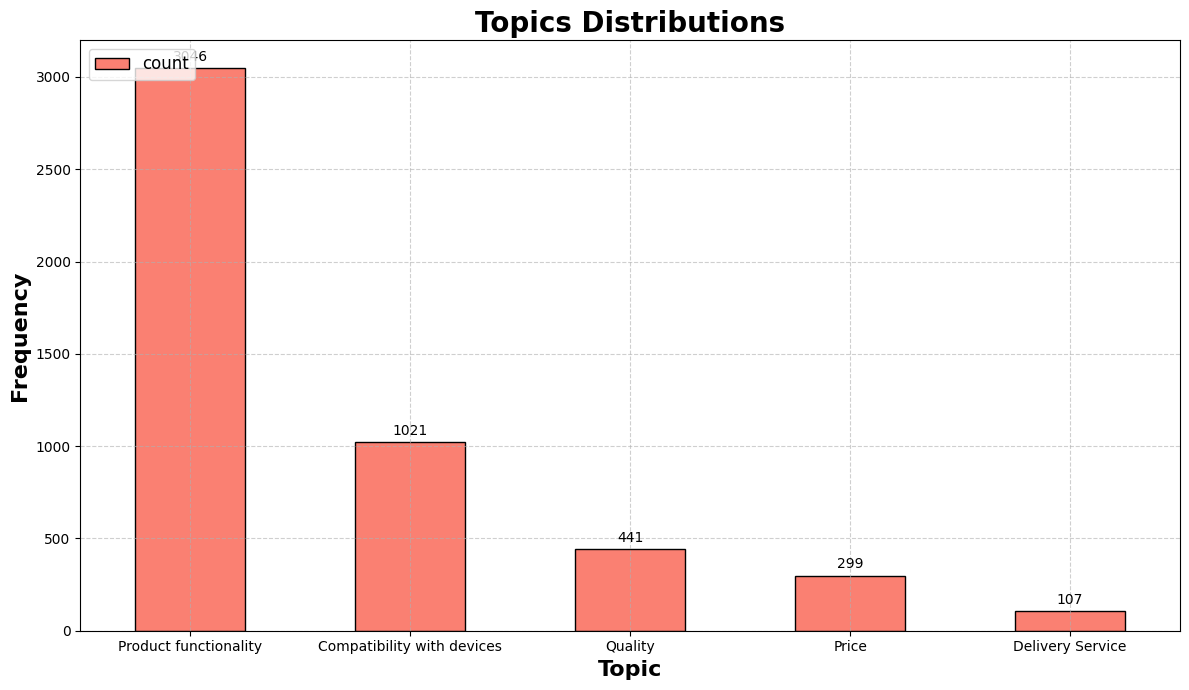

In [25]:
real_topic_counts = df['deberta_topics'].value_counts()

fig, ax = plt.subplots(figsize=(12, 7))
bars = real_topic_counts.plot(kind='bar', ax=ax, color=['salmon'], edgecolor='black')
ax.set_title('Topics Distributions', fontsize=20, fontweight='bold')
ax.set_xlabel('Topic', fontsize=16, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=16, fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.grid(True, linestyle='--', alpha=0.6)

for container in bars.containers:
    ax.bar_label(container, fmt='%.0f', padding=3) 

plt.legend(fontsize='large', title_fontsize='16', loc='upper left')
plt.tight_layout()
plt.show()

# Sentiment by Topic

In [26]:
topic_sentiment_count = df.groupby(['deberta_topics', 'sentiment']).size().unstack(fill_value=0)
topic_sentiment_count

sentiment,negative,neutral,positive
deberta_topics,,,
Compatibility with devices,209,267,545
Delivery Service,4,16,87
Price,12,24,263
Product functionality,80,388,2578
Quality,186,73,182


In [27]:
topic_percentages = topic_sentiment_count.div(topic_sentiment_count.sum(axis=1), axis=0) * 100
topic_percentages

sentiment,negative,neutral,positive
deberta_topics,,,
Compatibility with devices,20.470127,26.150833,53.379040
Delivery Service,3.738318,14.953271,81.308411
Price,4.013378,8.026756,87.959866
Product functionality,2.626395,12.738017,84.635588
Quality,42.176871,16.553288,41.269841


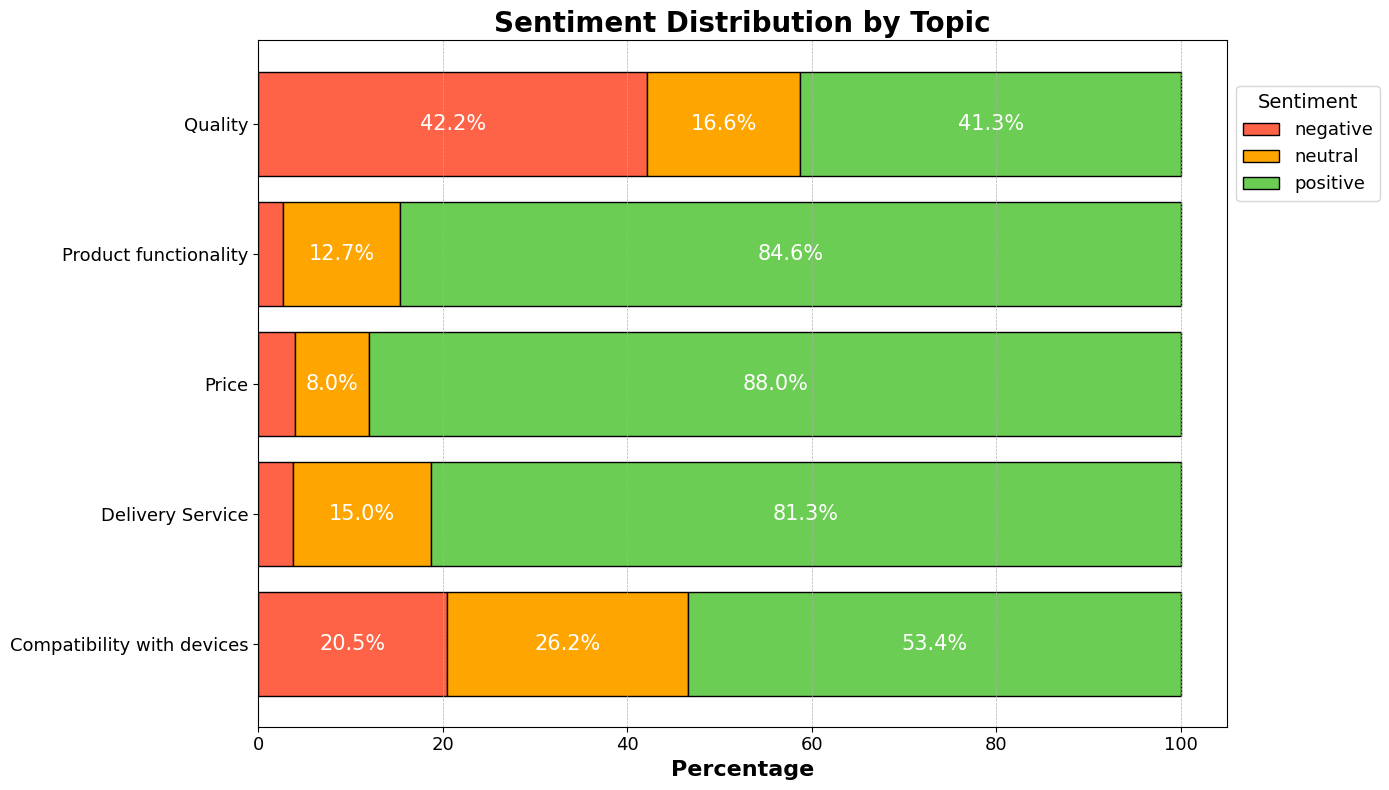

In [28]:
colors = {"negative": "#FF6347", "neutral": "orange", "positive": "#6BCD53"}

fig, ax = plt.subplots(figsize=(14, 8))
# Create a cumulative array to stack the bars
cumulative_size = np.zeros(len(topic_percentages))

for sentiment in ["negative", "neutral", "positive"]:  
    ax.barh(topic_percentages.index, topic_percentages[sentiment], left=cumulative_size, color=colors[sentiment], label=sentiment, edgecolor='black')
    cumulative_size += topic_percentages[sentiment].values  # Update the cumulative size

    # Adding data labels inside the bars for clarity
    for i, (value, name) in enumerate(zip(topic_percentages[sentiment], topic_percentages.index)):
        if value > 5: 
            ax.text(cumulative_size[i] - (value / 2), i, f"{value:.1f}%", va='center', ha='center', fontweight='medium', color='white', fontsize=15)

ax.set_xlabel('Percentage', fontsize=16, fontweight='bold')
ax.set_title('Sentiment Distribution by Topic', fontsize=20, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(topic_percentages.index, fontsize=13)
plt.legend(title='Sentiment', fontsize=13, title_fontsize=14, loc='center left', bbox_to_anchor=(1, 0.85))
plt.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')
plt.tight_layout()
plt.show()

This highlights which topics are most critical and are impacting the performance of our application. For example, the "Quality" topic has a higher proportion of negative sentiment compared to others, indicating that we may need to address issues related to product quality.

A more refined approach for the future would involve improving the descriptions for each topic and potentially introducing new topics to capture more granular feedback. This would provide deeper insights and help target specific areas for improvement.

## Topics Overtime

This plot helps correlate topics with sentiment trends over time. By analyzing it, we can determine if spikes in negative sentiment are linked to specific topics, providing insights into potential issues. For example, a surge in negative feedback might be directly tied to concerns with a particular feature or aspect of the product. This allows us to pinpoint areas requiring attention and improvement.

In [29]:
# This code generates a time-series plot showing the distribution of different topics over time, with stacked areas representing the number of mentions for each topic.

if 'reviewTime' in df.columns:
    df['reviewTime'] = pd.to_datetime(df['reviewTime'])
    df.set_index('reviewTime', inplace=True)

daily_topic_counts = df.groupby([df.index.date, 'deberta_topics']).size().unstack(fill_value=0)

sorted_columns = ['Compatibility with devices', 'Price', 'Product functionality', 'Quality', 'Delivery Service']
daily_topic_counts = daily_topic_counts.reindex(sorted_columns, axis=1, fill_value=0)

topic_colors = {
    'Compatibility with devices': 'red',
    'Price': 'blue',
    'Product functionality': 'purple',
    'Quality': 'orange',
    'Delivery Service': 'green'
}
colors = [topic_colors[topic] for topic in sorted_columns]

fig_topic_overtime = go.Figure()
for topic, color in zip(sorted_columns, colors):
    fig_topic_overtime.add_trace(go.Scatter(
        x=daily_topic_counts.index,
        y=daily_topic_counts[topic],
        stackgroup='one',
        name=topic,
        mode='lines',
        line=dict(width=0.5, color=color),
        fill='tonexty',
        hoverinfo='x+y'
    ))

fig_topic_overtime.update_layout(
    title={
        'text': 'Topic Distribution Over Time',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Arial, sans-serif",
            size=24,
            color="black"
        ),
    },
    xaxis_title="Day",
    yaxis_title="Number of Mentions",
    legend_title='Topics',
    xaxis=dict(
        title_font=dict(size=18, color='black'),
        tickmode='auto',
        nticks=10,
        tickfont=dict(size=16, color='black')
    ),
    yaxis=dict(
        title_font=dict(size=18, color='black'),
        tickfont=dict(size=16, color='black'),
        gridcolor='#e6e8eb',
        gridwidth=0.5,
    ),
    legend=dict(
        title_font=dict(color='black', size=18),
        font=dict(color='black')
    ),
    hovermode='x unified',
    plot_bgcolor='rgba(255, 255, 255, 1)',
    paper_bgcolor='rgba(255, 255, 255, 1)'
)

fig_topic_overtime.show()


# Improvements

- Fine-tune the model for better accuracy.
- Develop topics that are more closely aligned with the application's context.
- Create more precise and accurate descriptions for each topic.
- Implement out-of-distribution detection to filter out comments unrelated to any topic, saving processing time and costs on irrelevant feedback.
